In [2]:
# Import required dependancies.
import pandas as pd
import numpy as np
import hvplot.pandas
import yfinance as yf
import pandas_ta as ta
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

## Pull data from yfinance, then prepare the dataframe

In [3]:
# Downloaded 2 years worth of hourly data from yfinance for features used to train ML model and filled NaN with the data from the last row.
indicator_tickers = ['^TNX','^IRX','DX-Y.NYB','SPY','ETH-USD']
yf_data = yf.download(
    indicator_tickers, 
    period='2y', 
    interval='60m', 
    ignore_tz = False, 
    prepost = True, 
    parse_dates=True, 
    infer_datetime_format=True, 
    tz = 'utc'
)['Adj Close']
    
yf_data.fillna(method='pad', inplace=True)
yf_data.head()

[*********************100%***********************]  5 of 5 completed


,DX-Y.NYB,ETH-USD,SPY,^IRX,^TNX
Datetime,,,,,
2020-11-17 21:00:00+00:00,92.456001,478.521729,NaN,NaN,NaN
2020-11-17 22:00:00+00:00,92.431000,478.747345,NaN,NaN,NaN
2020-11-17 23:00:00+00:00,92.438004,480.341614,NaN,NaN,NaN
2020-11-18 00:00:00+00:00,92.458000,484.705475,NaN,NaN,NaN
2020-11-18 01:00:00+00:00,92.496002,484.981354,NaN,NaN,NaN


In [4]:
# Adding possible leading indicator columns for pct change & yield curves of 10 year and 2 year US Treasury bonds.
# Added other possible indicators columns as percent changed.
yf_data['UST_curve'] = yf_data['^TNX'] - yf_data['^IRX']
yf_data['^TNX_PC'] = yf_data['^TNX'].pct_change()
yf_data['DX-Y.NYB_PC'] = yf_data['DX-Y.NYB'].pct_change()
yf_data['SPY_PC'] = yf_data['SPY'].pct_change()  
yf_data['ETH-USD_PC'] = yf_data['ETH-USD'].pct_change()
# Review the DataFrame
yf_data.tail()

,DX-Y.NYB,ETH-USD,SPY,^IRX,^TNX,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC
Datetime,,,,,,,,,,
2022-11-17 20:00:00+00:00,106.644997,1201.986328,392.070007,4.113,3.775,-0.338,0.0,-0.000459,0.000000,-0.002923
2022-11-17 20:30:00+00:00,106.644997,1201.986328,394.269989,4.113,3.775,-0.338,0.0,0.000000,0.005611,0.000000
2022-11-17 21:00:00+00:00,106.636002,1206.967163,394.250000,4.113,3.775,-0.338,0.0,-0.000084,-0.000051,0.004144
2022-11-17 21:15:10+00:00,106.639999,1206.967163,394.250000,4.113,3.775,-0.338,0.0,0.000037,0.000000,0.000000
2022-11-17 21:23:00+00:00,106.639999,1207.378540,394.250000,4.113,3.775,-0.338,0.0,0.000000,0.000000,0.000341


In [5]:
# Dropped the columns that we don't need.
yf_data = yf_data.drop(columns=['^IRX', 'ETH-USD', 'SPY', '^TNX', 'DX-Y.NYB'])

In [6]:
# Setting the crypto that we want to trade
target_crypto = 'ETH-USD'
# Pulling in data from yfinance for target crypto
target_df = yf.download(
    target_crypto, 
    period='2y', 
    interval='60m', 
    ignore_tz = False, 
    prepost = True, 
    parse_dates=True, 
    infer_datetime_format=True, 
    tz = 'utc'
)
# Added ta features to use as features in ML as well as to generate trade signals
shortEMA = 120
longEMA = 504
target_df['RSI'] = target_df.ta.rsi(length=336)
target_df['ATR'] = ta.atr(target_df.High, target_df.Low, target_df.Close, length=20)
target_df['ShortEMA'] = ta.ema(target_df.Close, length=shortEMA)
target_df['LongEMA'] = ta.ema(target_df.Close, length=longEMA)
target_df.tail(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,ShortEMA,LongEMA
Datetime,,,,,,,,,,
2022-11-17 21:00:00+00:00,1202.084595,1206.967163,1202.02478,1206.967163,1206.967163,31477760,47.000978,8.168926,1238.029078,1351.955194
2022-11-17 21:23:00+00:00,1207.378540,1207.378540,1207.37854,1207.378540,1207.378540,0,47.009085,7.781049,1237.522457,1351.382613


In [7]:
# Dropping the columns that we don't need from the target DataFrame
target_df = target_df.drop(columns=['Open','High','Low','Close','Volume'])
target_df.tail()

,Adj Close,RSI,ATR,ShortEMA,LongEMA
Datetime,,,,,
2022-11-17 18:00:00+00:00,1211.063232,47.060833,8.690178,1239.731298,1353.717235
2022-11-17 19:00:00+00:00,1205.510254,46.964215,8.556353,1239.165661,1353.130277
2022-11-17 20:00:00+00:00,1201.986328,46.902924,8.336720,1238.551127,1352.531687
2022-11-17 21:00:00+00:00,1206.967163,47.000978,8.168926,1238.029078,1351.955194
2022-11-17 21:23:00+00:00,1207.378540,47.009085,7.781049,1237.522457,1351.382613


In [8]:
# Combined both DataFrames using merge.
df_model = pd.merge(yf_data, target_df, left_index=True, right_index=True).dropna()
df_model

,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,Adj Close,RSI,ATR,ShortEMA,LongEMA
Datetime,,,,,,,,,,
2020-12-08 20:00:00+00:00,0.845,0.000000,-0.000198,0.000000,-0.012385,564.185547,50.699563,4.286534,588.880381,559.938999
2020-12-08 21:00:00+00:00,0.845,0.000000,0.000143,-0.000162,0.003735,566.292847,50.811682,4.344742,588.507033,559.964163
2020-12-08 22:00:00+00:00,0.845,0.000000,-0.000165,0.000838,-0.008605,561.419861,50.545076,4.515981,588.059311,559.969928
2020-12-08 23:00:00+00:00,0.845,0.000000,-0.000077,0.000783,-0.011981,554.693481,50.180556,4.737713,587.507810,559.949031
2020-12-09 00:00:00+00:00,0.845,0.000000,-0.000429,0.000000,-0.004932,551.957886,50.033369,4.759601,586.920208,559.917383
...,...,...,...,...,...,...,...,...,...,...
2022-11-17 18:00:00+00:00,-0.331,0.001853,-0.001226,0.000000,0.002013,1211.063232,47.060833,8.690178,1239.731298,1353.717235
2022-11-17 19:00:00+00:00,-0.338,-0.002378,0.000112,0.000000,-0.004585,1205.510254,46.964215,8.556353,1239.165661,1353.130277
2022-11-17 20:00:00+00:00,-0.338,0.000000,-0.000459,0.000000,-0.002923,1201.986328,46.902924,8.336720,1238.551127,1352.531687


In [9]:
# Created an hvplot to see the short & long EMAs compared to the closing price of target crypto
df_model.hvplot(y=['Adj Close', 'ShortEMA', 'LongEMA'])

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

## Create the trading signals

In [10]:
# Generated the trading signal 0 or 1, where 1 is short EMA greater than long EMA and 0 when the condition is not met
df_model['Signal'] = 0
df_model["Signal"][shortEMA:] = np.where(
    df_model['ShortEMA'][shortEMA:] > df_model['LongEMA'][shortEMA:], 1.0, 0.0
)
df_model.head()

C:\Users\mmaro\AppData\Local\Temp\ipykernel_18096\280147395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["Signal"][shortEMA:] = np.where(


,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,Adj Close,RSI,ATR,ShortEMA,LongEMA,Signal
Datetime,,,,,,,,,,,
2020-12-08 20:00:00+00:00,0.845,0.0,-0.000198,0.000000,-0.012385,564.185547,50.699563,4.286534,588.880381,559.938999,0
2020-12-08 21:00:00+00:00,0.845,0.0,0.000143,-0.000162,0.003735,566.292847,50.811682,4.344742,588.507033,559.964163,0
2020-12-08 22:00:00+00:00,0.845,0.0,-0.000165,0.000838,-0.008605,561.419861,50.545076,4.515981,588.059311,559.969928,0
2020-12-08 23:00:00+00:00,0.845,0.0,-0.000077,0.000783,-0.011981,554.693481,50.180556,4.737713,587.507810,559.949031,0
2020-12-09 00:00:00+00:00,0.845,0.0,-0.000429,0.000000,-0.004932,551.957886,50.033369,4.759601,586.920208,559.917383,0


In [11]:
# Created an Entry/Exit column
df_model['Entry/Exit'] = df_model['Signal'].diff()
df_model.tail()

,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,Adj Close,RSI,ATR,ShortEMA,LongEMA,Signal,Entry/Exit
Datetime,,,,,,,,,,,,
2022-11-17 18:00:00+00:00,-0.331,0.001853,-0.001226,0.000000,0.002013,1211.063232,47.060833,8.690178,1239.731298,1353.717235,0,0.0
2022-11-17 19:00:00+00:00,-0.338,-0.002378,0.000112,0.000000,-0.004585,1205.510254,46.964215,8.556353,1239.165661,1353.130277,0,0.0
2022-11-17 20:00:00+00:00,-0.338,0.000000,-0.000459,0.000000,-0.002923,1201.986328,46.902924,8.336720,1238.551127,1352.531687,0,0.0
2022-11-17 21:00:00+00:00,-0.338,0.000000,-0.000084,-0.000051,0.004144,1206.967163,47.000978,8.168926,1238.029078,1351.955194,0,0.0
2022-11-17 21:23:00+00:00,-0.338,0.000000,0.000000,0.000000,0.000341,1207.378540,47.009085,7.781049,1237.522457,1351.382613,0,0.0


In [12]:
# Verifying the number of values in the "Entry/Exit" column.  It looks like we made some trades
df_model['Entry/Exit'].value_counts()

 0.0    16763
 1.0       14
-1.0       14
Name: Entry/Exit, dtype: int64

In [ ]:
# Visualized exit position relative to adj close price
exit = df_model[df_model['Entry/Exit'] == -1.0]['Adj Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)
# Visualized entry position relative to adj close price
entry = df_model[df_model['Entry/Exit'] == 1.0]['Adj Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)
# Visualized close price for the crypto
security_close = df_model[['Adj Close']].hvplot(
    line_color='black',
    ylabel='Price in $',
    width=1000,
    height=400
)
# Visualized Exponential Moving Averages
moving_avgs = df_model[['ShortEMA', 'LongEMA']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)
# Created the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Showed the plot
entry_exit_plot.opts(
    title="Ethereum - Short & Long EMA & Entry and Exit Points"
)

In [13]:
# Set the initial capital to be used for trading
initial_capital = float(100000)
# Set the trade size
trade_size = 75
# Buy a 75 ETH position when the dual moving average crossover Signal equals 1 (ShortEMA is greater than LongEMA)
# Sell a 75 ETH position when the dual moving average crossover Signal equals 0 (ShortEMA is less than LongEMA)
df_model['Position'] = trade_size * df_model['Signal']
# Determined the points in time where a 10 ETH position is bought or sold
df_model['Entry/Exit Position'] = df_model['Position'].diff()
# Multiplied the close price by the trade size, or the Position
df_model['Portfolio Holdings'] = df_model['Adj Close'] * df_model['Position']
# Subtracted the amount of either the cost or proceeds of the trade from the initiial capital invested
df_model['Portfolio Cash'] = initial_capital - (df_model['Adj Close'] * df_model['Entry/Exit Position']).cumsum()
# Calculated the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
df_model['Portfolio Total'] = df_model['Portfolio Cash'] + df_model['Portfolio Holdings']
# Calculated the portfolio daily returns
df_model['Portfolio Daily Returns'] = df_model['Portfolio Total'].pct_change()
# Calculated the portfolio cumulative returns
df_model['Portfolio Cumulative Returns'] = (1 + df_model['Portfolio Daily Returns']).cumprod() - 1
df_model.tail()

,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,Adj Close,RSI,ATR,ShortEMA,LongEMA,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Datetime,,,,,,,,,,,,,,,,,,,
2022-11-17 18:00:00+00:00,-0.331,0.001853,-0.001226,0.000000,0.002013,1211.063232,47.060833,8.690178,1239.731298,1353.717235,0,0.0,0,0.0,0.0,256395.951843,256395.951843,0.0,1.56396
2022-11-17 19:00:00+00:00,-0.338,-0.002378,0.000112,0.000000,-0.004585,1205.510254,46.964215,8.556353,1239.165661,1353.130277,0,0.0,0,0.0,0.0,256395.951843,256395.951843,0.0,1.56396
2022-11-17 20:00:00+00:00,-0.338,0.000000,-0.000459,0.000000,-0.002923,1201.986328,46.902924,8.336720,1238.551127,1352.531687,0,0.0,0,0.0,0.0,256395.951843,256395.951843,0.0,1.56396
2022-11-17 21:00:00+00:00,-0.338,0.000000,-0.000084,-0.000051,0.004144,1206.967163,47.000978,8.168926,1238.029078,1351.955194,0,0.0,0,0.0,0.0,256395.951843,256395.951843,0.0,1.56396
2022-11-17 21:23:00+00:00,-0.338,0.000000,0.000000,0.000000,0.000341,1207.378540,47.009085,7.781049,1237.522457,1351.382613,0,0.0,0,0.0,0.0,256395.951843,256395.951843,0.0,1.56396


In [14]:
# Visualized exit position relative to total portfolio value
exit = df_model[df_model['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualized entry position relative to total portfolio value
entry = df_model[df_model['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualized the value of the total portfolio
total_portfolio_value = df_model[['Portfolio Total']].hvplot(
    line_color='black',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlayed the plots into one chart
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="ETH-USD - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Datetime]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Datetime]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Datetime]   (Portfolio Total)

In [15]:
# Dropped NaN value rows.
df_model.dropna().head()

,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,Adj Close,RSI,ATR,ShortEMA,LongEMA,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Datetime,,,,,,,,,,,,,,,,,,,
2020-12-08 22:00:00+00:00,0.845,0.0,-0.000165,0.000838,-0.008605,561.419861,50.545076,4.515981,588.059311,559.969928,0,0.0,0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-08 23:00:00+00:00,0.845,0.0,-0.000077,0.000783,-0.011981,554.693481,50.180556,4.737713,587.507810,559.949031,0,0.0,0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-09 00:00:00+00:00,0.845,0.0,-0.000429,0.000000,-0.004932,551.957886,50.033369,4.759601,586.920208,559.917383,0,0.0,0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-09 01:00:00+00:00,0.845,0.0,0.000055,0.000000,-0.007073,548.053955,49.824191,4.904034,586.277791,559.870399,0,0.0,0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-09 02:00:00+00:00,0.845,0.0,-0.000462,0.000000,0.004369,550.448425,49.952908,4.910700,585.685570,559.833084,0,0.0,0,0.0,0.0,100000.0,100000.0,0.0,0.0


## Using Machine Learning to predict the "Signal"

In [16]:
# Assigned a copy of the technical variable columns to a new DataFrame called `X` and lag it.
X = df_model[['ShortEMA', 'LongEMA', 'UST_curve', '^TNX_PC', 'DX-Y.NYB_PC', 'SPY_PC', 'ETH-USD_PC', 'RSI', 'ATR']].shift().dropna().copy()
# Copied the new "signal" column to a new Series called `y`.
y = df_model['Signal']
display(X.head(1))
display(y.head(2))

,ShortEMA,LongEMA,UST_curve,^TNX_PC,DX-Y.NYB_PC,SPY_PC,ETH-USD_PC,RSI,ATR
Datetime,,,,,,,,,
2020-12-08 21:00:00+00:00,588.880381,559.938999,0.845,0.0,-0.000198,0.0,-0.012385,50.699563,4.286534


Datetime
2020-12-08 20:00:00+00:00    0
2020-12-08 21:00:00+00:00    0
Name: Signal, dtype: int64

In [17]:
# Used the following code to select the start of the training period: `training_begin = X.index.min()`
training_begin = X.index.min()
print(training_begin)

# Used the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
training_end = X.index.min() + DateOffset(months=12)
print(training_end)

# Generated the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generated the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Used StandardScaler to scale the X_train and X_test data.
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Used RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

2020-12-08 21:00:00+00:00
2021-12-08 21:00:00+00:00


In [18]:
# Created the classifier model.
model = SVC()
 
# Fitted the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)

# Used the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)

# Evaluated the model using a classification report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5807
           1       0.97      0.94      0.95      5807

    accuracy                           0.95     11614
   macro avg       0.96      0.95      0.95     11614
weighted avg       0.96      0.95      0.95     11614



## New Code: Backtest the Trading Algorithm

In [19]:
# Used the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
# Evaluated the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      5907
           1       0.57      0.93      0.70      2340

    accuracy                           0.78      8247
   macro avg       0.76      0.82      0.76      8247
weighted avg       0.85      0.78      0.79      8247



In [20]:
# Created a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns'] = testing_signal_predictions
predictions_df['predicted_returns'].value_counts()

0    4400
1    3847
Name: predicted_returns, dtype: int64

In [21]:
# Added in actual returns and calculate trading returns
predictions_df['actual_returns'] = df_model['Portfolio Daily Returns']
predictions_df['trading_algorithm_returns'] = predictions_df['actual_returns'] * predictions_df['predicted_returns']

<AxesSubplot: xlabel='Datetime'>

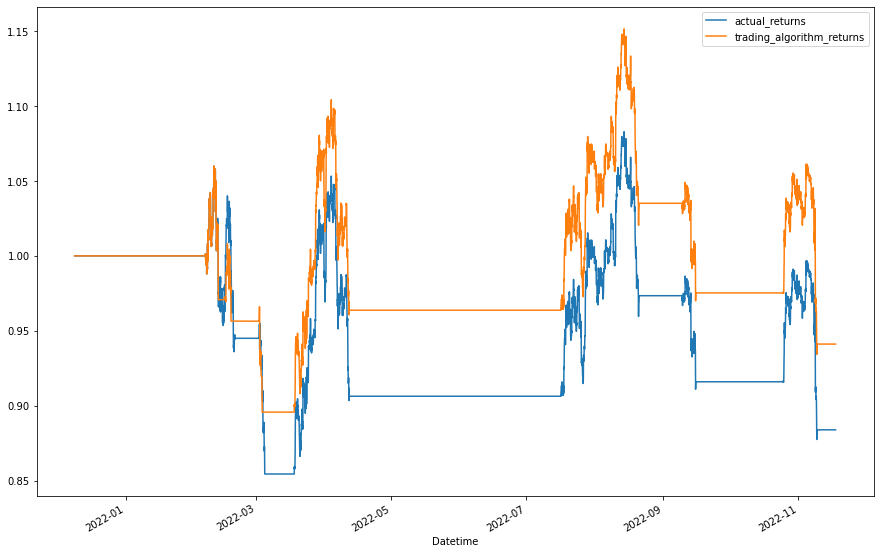

In [22]:
# Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot(figsize=(15,10))